Contents __TODO: remove when done (only for development purpose)__

+ [Basic prediction pattern used in this lecture](#prediction)
+ [Incomplete / missing data](#missing-data)
+ [Incorrect data](#incorrect-data)
+ [Biased data](#biased-data)
+ [More ideas](#more-ideas)

In [ ]:
# Cell to hide - just an option

import pandas as pd
pd.set_option('display.max_columns', 27)

In this section, we want to try out a few experiments with the 2 datasets we have. You will perform some simple prediction tasks from the data, predicting for example the length of a ship, or its future trajectory.

For now, you should only focus on the prediction task, using the raw data as you received them.

## Basic prediction pattern used in this lecture <a class="anchor" id="prediction"></a>

__TODO: probably move this part and the corresponding functions to either the intro or the appendix. I think it's better if the students can use just knn_regression or rf_trajectory without caring too much about what's going on in there.__

This lecture is about data quality, so we do not want to focus too much on the task of prediction, but more on the data themselves. For this reason, the prediction functions have been simplified as much as possible, and we will use some simple algorithms from some Python libraries.

To understand how a simple task of supervised learning is led, refer to the introductory part (link) __TODO: link to the introduction about supervised learning__.

We will now quickly go through the prediction task.

There are 2 kinds of supervised prediction tasks: classification and regression. Here, they will be tackled the same way, only the algorithm used and the way of measuring the performance change. We will explore together the regression 

In [2]:
# KNN regression
def knn_regression(df, x,  y):
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_absolute_error
    
    x_train, x_test, y_train, y_test = train_test_split(df[x], df[y], test_size = 0.2, random_state = 0)
    
    x_train = x_train.fillna(value = 0)
    x_test = x_test.fillna(value = 0)
    y_train = y_train.fillna(value = 0)
    y_test = y_test.fillna(value = 0)
    
    knn = KNeighborsRegressor(n_neighbors = 25)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    
    return mean_absolute_error(predictions, y_test)

In [3]:
# KNN classification
def knn_classification(df, x,  y):
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    
    x_train, x_test, y_train, y_test = train_test_split(df[x], df[y], test_size = 0.2, random_state = 0)
    
    x_train = x_train.fillna(value = 0)
    x_test = x_test.fillna(value = 0)
    y_train = y_train.fillna(value = 0)
    y_test = y_test.fillna(value = 0)
    
    knn = KNeighborsClassifier(n_neighbors = 25)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    
    return accuracy_score(predictions, y_test)

In [89]:
def rf_trajectory(df, split, clas):
    '''
    Do time series prediction on df
    in:
    df: pandas DataFrame
    split: integer, between 0 and 1, percentage of train/test split
    clas: string, the name of the attribute to predict (do it separatly for latitude and longitude)
    '''
    import numpy as np
    from sklearn.metrics import mean_absolute_error
    from sklearn.ensemble import RandomForestRegressor
    
    # First, we create a new dataset with 2 additional columns for prediction:
    # - previous_clas: contains the value of the class attribute of the previous row (example: previous latitude value)
    # - diff_clas: the difference between the previous value and the current value for the class attribute
    
    df2 = pd.DataFrame(columns = ['TripID', 'BaseDateTime', clas, 'previous_clas', 'diff_clas'])
    
    df2['TripID'] = df['TripID']
    df2['BaseDateTime'] = df['BaseDateTime']
    df2[clas] = df[clas]
    
    previous_tripid = 'first'
    
    for index, row in df2.sort_values(['TripID', 'BaseDateTime']).iterrows():
        if previous_tripid != row['TripID']: # new trip
            previous_tripid = row['TripID']
            previous_clas = row[clas]
        
        df2.loc[index, 'previous_clas'] = previous_clas
        previous_clas = row[clas]
        
    df2['diff_clas'] = df2[clas] - df2['previous_clas']
    
    df2['previous_clas'] = pd.to_numeric(df2['previous_clas'])
    df2['diff_clas'] = pd.to_numeric(df2['diff_clas'])
    
    # Split training and testing sets: the training set is the first part of the data in the chronological order
    nb_train = int(split * len(df2))
    nb_test = int(len(df2) - nb_train)
    train = df2.head(nb_train)
    test = df2.tail(nb_test)
    
    # Baseline prediction: always predicts the last position
    baseline = mean_absolute_error(test[clas], test['previous_clas'])
    #print('Baseline: mean absolute error = %.5f' % baseline)
    
    # Random Forest prediction
    # Drop the timestamp columns because they cannot be processed by the random forest algorithm
    x_train, x_test = train.drop(columns = [clas, 'BaseDateTime'], axis = 1), test.drop(columns = [clas, 'BaseDateTime'], axis = 1)
    y_train, y_test = train[clas].values, test[clas].values

    rf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1, random_state = 0)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    error = mean_absolute_error(predictions, y_test)
    
    #print('Random Forest: mean absolute error = %.5f' % error)
    
    return train, test, predictions, baseline, error

## Incomplete / missing data <a class="anchor" id="missing-data"></a>

### 1
Exercise of prediction with and without NaN:
+ once it gives better results, example for prediction of Width from Length > because 0 Length might lower the mean value. Compare length and width values, plot graphs, compare NaN in both columns
+ once it gives worse results, identify why (because more NaN than non-NaN so prediction error is calculated on an easy problem (0 > 0)). Example, predict MeanSOG from DepLat, ArrLat, DepLon, ArrLon or from VesselType

In [1]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

In [5]:
# Prediction of Length from Width
x = ['Length']
y = ['Width']

static_selected = static_data.dropna()

mae_alldata = knn_regression(static_data, x, y)
mae_nona = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mae_alldata))
print('MAE without NaN: ' + str(mae_nona))

MAE with all data: 2.73451052631579
MAE without NaN: 2.0717238095238097


In [6]:
# Prediction of MeanSOG from start and end positions
x = ['DepLat', 'ArrLat', 'DepLon', 'ArrLon']
y = ['MeanSOG']

static_selected = static_data.dropna()

mae_alldata = knn_regression(static_data, x, y)
mae_nona = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mae_alldata))
print('MAE without NaN: ' + str(mae_nona))

MAE with all data: 0.9136499460275772
MAE without NaN: 1.9541572056893803


In [7]:
# Prediction of MeanSOG from VesselType
x = ['VesselType']
y = ['MeanSOG']

static_selected = static_data.dropna()

mae_alldata = knn_regression(static_data, x, y)
mae_nona = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mae_alldata))
print('MAE without NaN: ' + str(mae_nona))

MAE with all data: 0.9494952790387338
MAE without NaN: 3.0201554291315684


### 2
Exercise of trajectory prediction from one trip with and without gap of missing data

In [9]:
import pandas as pd

dynamic_data = pd.read_csv('./dynamic_data.csv')

In [79]:
# Choose the trip to do the prediction on, and do the prediction twice: for latitude and longitude separately

tripid = 221

df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(df, 0.75, 'LAT')
train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(df, 0.75, 'LON')

Baseline: mean absolute error = 0.00136
Random Forest: mean absolute error = 0.00136
Baseline: mean absolute error = 0.00337
Random Forest: mean absolute error = 0.06779


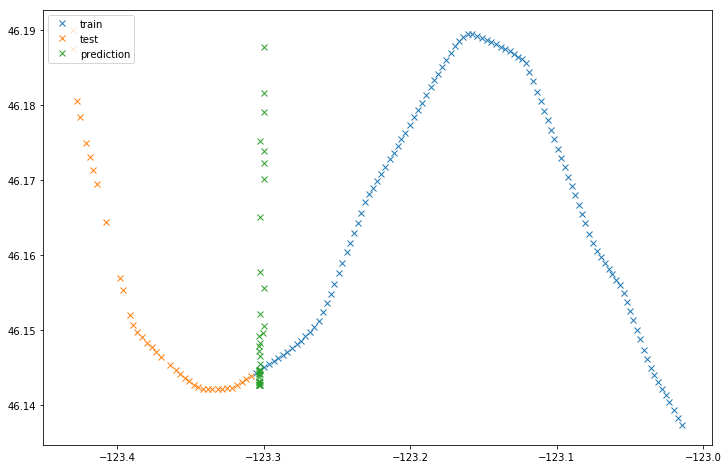

In [80]:
# Plot the result

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
plt.legend(loc = 'upper left')

In [86]:
# Do the prediction on the same trip but with a gap of missing values

df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')

# Drop 25% of the trip information, between 25 and 50% chronogically
df = df.reset_index().drop(columns = ['index']) # reindex to be able to make actions on the index value
index_start = df.index[int(0.25 * len(df))]
index_end = df.index[int(0.50 * len(df))]

gap_df = df.loc[df.index < index_start]
gap_df = gap_df.append(df.loc[df.index > index_end])

Baseline: mean absolute error = 0.00138
Random Forest: mean absolute error = 0.00208
Baseline: mean absolute error = 0.00336
Random Forest: mean absolute error = 0.06603


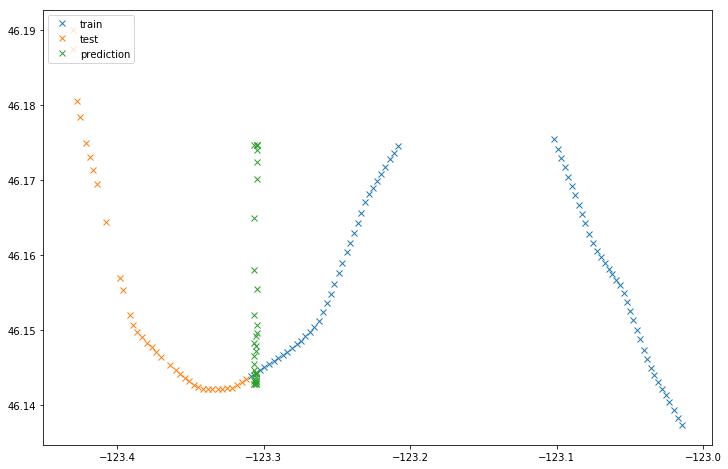

In [85]:
# Prediction and result

train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(gap_df, 0.67, 'LAT')
train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(gap_df, 0.67, 'LON')

plt.figure(figsize=(12,8))
plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
plt.legend(loc = 'upper left')

In [99]:
# compare for other trip

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def compare_pred(tripid):

    df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
    train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(df, 0.75, 'LAT')
    train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(df, 0.75, 'LON')

    mean_baseline = (baseline_lat + baseline_lon)/2
    mean_rf = (error_lat + error_lon)/2
    print('Mean baseline: %.5f' % mean_baseline)
    print('Mean RF: %.5f' % mean_rf)

    plt.figure(figsize=(12,8))
    plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
    plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
    plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
    plt.legend(loc = 'upper left')

    df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
    df = df.reset_index().drop(columns = ['index']) # reindex to be able to make actions on the index value
    index_start = df.index[int(0.25 * len(df))]
    index_end = df.index[int(0.50 * len(df))]

    gap_df = df.loc[df.index < index_start]
    gap_df = gap_df.append(df.loc[df.index > index_end])

    train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(gap_df, 0.67, 'LAT')
    train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(gap_df, 0.67, 'LON')

    mean_baseline = (baseline_lat + baseline_lon)/2
    mean_rf = (error_lat + error_lon)/2
    print('Mean baseline: %.5f' % mean_baseline)
    print('Mean RF: %.5f' % mean_rf)

    plt.figure(figsize=(12,8))
    plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
    plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
    plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
    plt.legend(loc = 'upper left')
    
interact(compare_pred,
         tripid = widgets.BoundedIntText(value = 1,
                                         min = 1,
                                         max = 1520,
                                         step = 1,
                                         description = 'TripID [1 ; 1520]:',
                                         disabled = False,))

interactive(children=(BoundedIntText(value=1, description='TripID [1 ; 1520]:', max=1520, min=1), Output()), _…

<function __main__.compare_pred(tripid)>

## Incorrect data <a class="anchor" id="incorrect-data"></a>

Exercise of prediction with wrong data
+ wrong unit of measurement for, for example, length or width
+ try misusing latitude and longitude values, and get for example cities from it

## Biased data <a class="anchor" id="biased-data"></a>

### 1
Exercise of prediction using immobile / mobile trips

### 2
Exercise of prediction with a lot of identical data vs. normal dataset (error in copy)

## More ideas <a class="anchor" id="more-ideas"></a>

+ Try to predict with something that does not make sense (example: using ID attribute as a number)
+ or using Length as a category
+ mixing regression and classification